In [16]:
import matplotlib.pyplot as plt
import nltk.tokenize
import pandas as pd
import sklearn.preprocessing
import sklearn.cluster
import sklearn.decomposition
import sklearn.feature_extraction
import numpy as np
import sys
sys.path.append('..')
import nltk
import pickle
import seaborn as sns

IMG_PATH = '../rapport/img/'
SAVE_IMGS = True

DOES_EMBED = True
COMPUTE_BERT_SCORE = True
EXCEL_DATA= False

image_name = lambda x: IMG_PATH + x + ('_embed' if DOES_EMBED else '_count') + ('_excel' if EXCEL_DATA else "") + '.png'
call_figure = lambda: plt.figure(figsize=(6, 4), dpi=300)

In [17]:
%load_ext autoreload
%autoreload 2

from src import helpers, pipelines
from src import evaluation
from src.helpers import Duc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [18]:
def load_data():
    if EXCEL_DATA:
        dataset=pd.read_excel('../data/dataset.xlsx')
        content=dataset['content']
        parsed_content=pipelines.parse_list_of_texts(content)
        refs_mono=np.array(dataset['human_summary'])
        for i in range(len(refs_mono)):
            refs_mono[i]=refs_mono[i].replace(".",". ")
            refs_mono[i]=refs_mono[i].replace("!","! ")
            refs_mono[i]=refs_mono[i].replace("?","? ")
        refs_mono=list(refs_mono)
        refs_plur=[ [a] for a in refs_mono]
    else:
        d = pickle.load(open('../out/task_12.pkl', 'rb'))
        parsed_content = d.clusters_corpuses()
        parsed_content = [[a for a in b if len(a) > (5 if DOES_EMBED else 20)] for b in parsed_content]
        refs_plur = list(d.summaries_texts())
        refs_mono = [a[0] for a in d.summaries_texts()]
    return parsed_content,refs_mono,refs_plur
parsed_content,refs_mono,refs_plur=load_data()

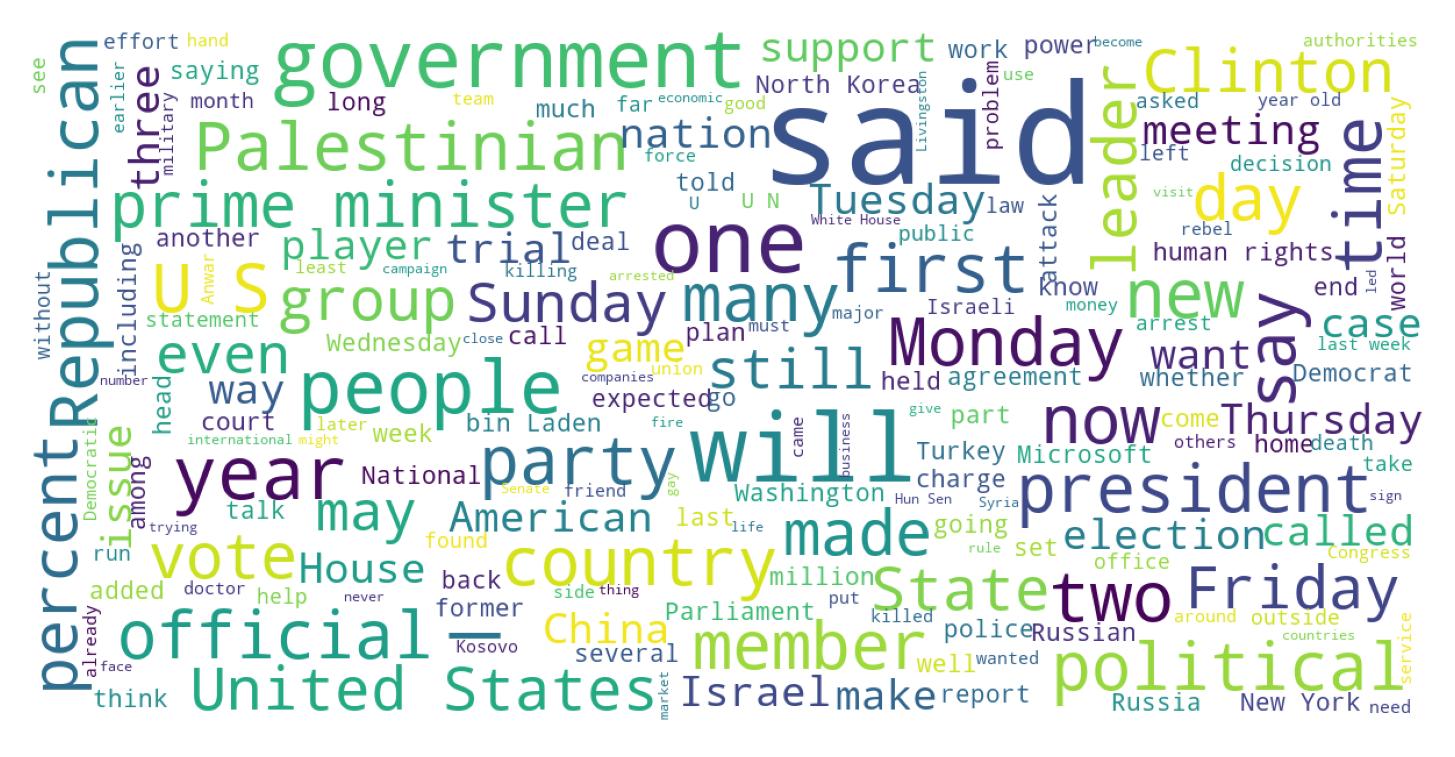

In [4]:
call_figure()
helpers.show_wordcloud(' '.join([' '.join(a) for a in parsed_content]))

In [5]:

params = {'nb_sentences': -1}  #-1 pour meme nombre de phrases que le resumé humain

if DOES_EMBED:
    if EXCEL_DATA:
        with open("../out/mpnet_excel", "rb") as f:
            matrixes = pickle.load(f)
            
    else:
        with open("../out/mpnet.pkl", "rb") as f:
            matrixes = pickle.load(f)
else:
    params.update({'remove_stop': True, 'min_df': 0., 'max_df': 1.})
    matrixes = pipelines.preprocess_duc(parsed_content,
                                        remove_stopwords=params['remove_stop'],
                                        min_df=params['min_df'],
                                        max_df=params['max_df'])

matrixes_norm = [sklearn.preprocessing.normalize(X, axis=1, norm='l2') for X in matrixes]

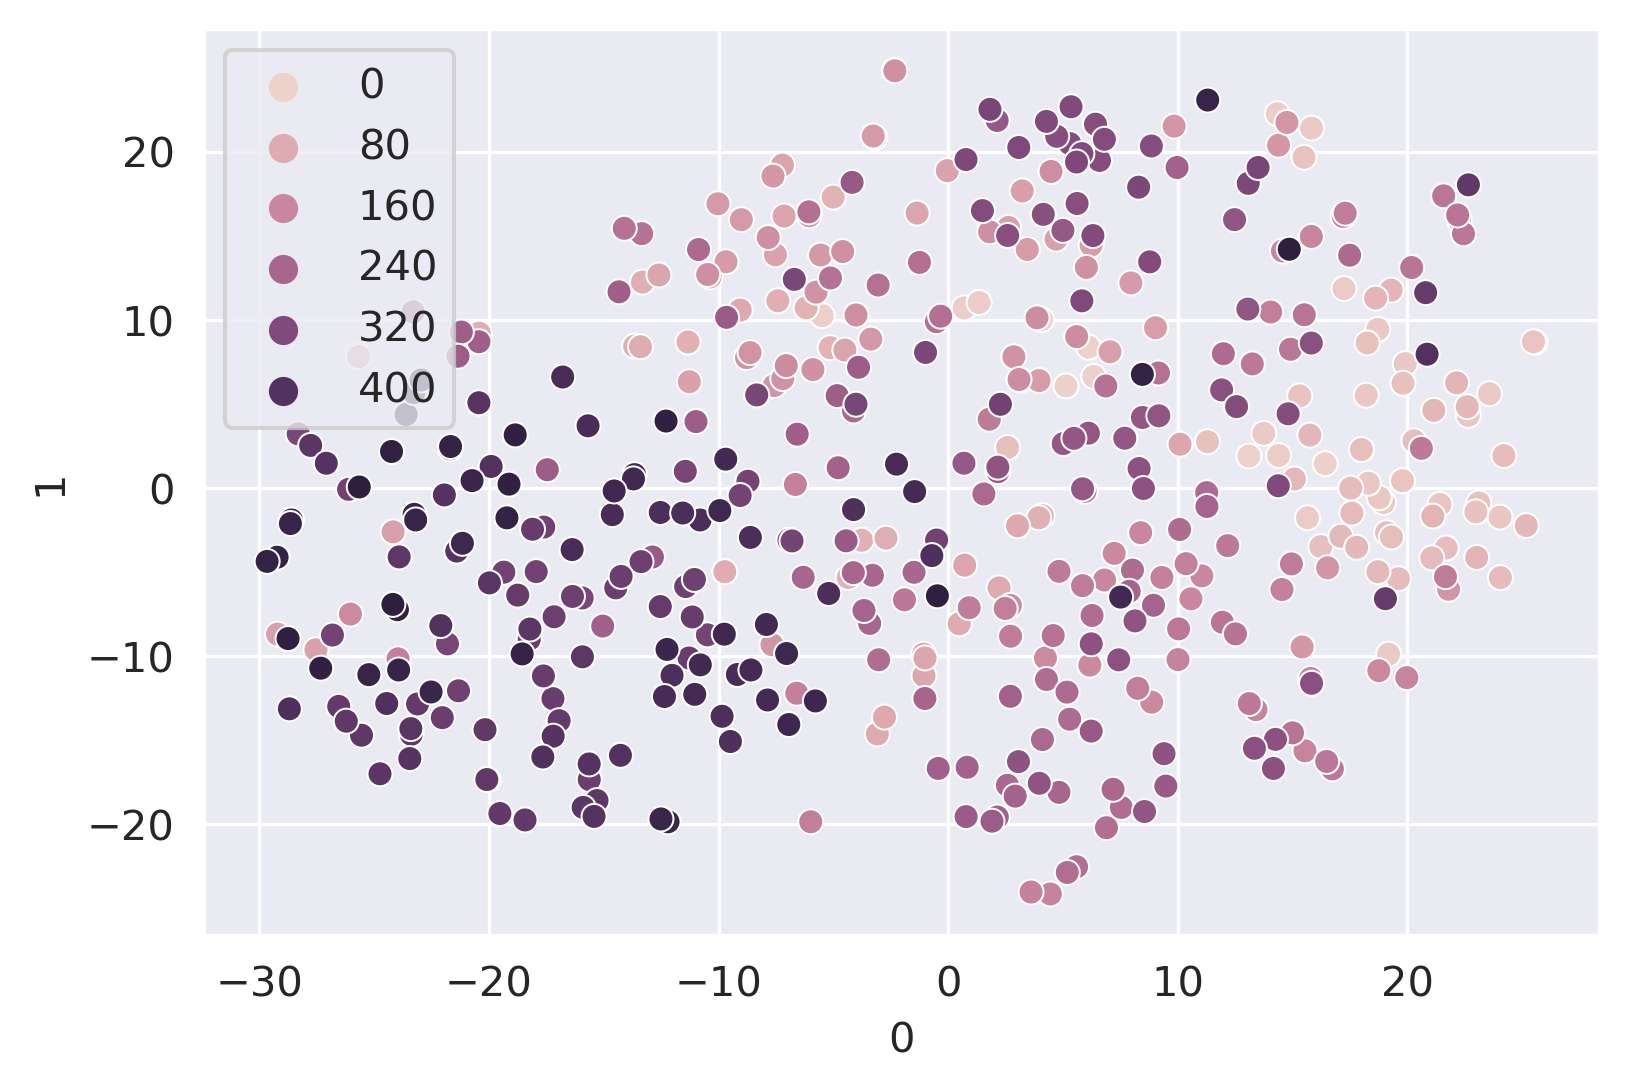

In [6]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random')
reduced_clusters = pd.DataFrame(tsne.fit_transform(matrixes[0]))
call_figure()
sns.scatterplot(data=reduced_clusters, x=0, y=1, hue=np.arange(len(reduced_clusters)))

if SAVE_IMGS:
    plt.savefig(image_name('tsne'))
plt.show()

# Clustering

In [7]:
# on cree l'iterator pour le nombre de phrases du resumé
if params['nb_sentences'] > 0:
    nb_sentences = [params['nb_sentences'] for i in range(len(refs_mono))]
else:
    nb_sentences = [len(nltk.tokenize.sent_tokenize(summi)) for summi in refs_mono]

model_summaries = dict()

In [8]:
model_summaries['kmeans'],outliers = pipelines.kmeans_summaries(nb_sentences, matrixes_norm, parsed_content,return_outliers=True)

In [9]:
model_summaries['svd'],outliersNew = pipelines.svd_summaries(nb_sentences, matrixes_norm, parsed_content,return_outliers=True)
outliers+=outliersNew

In [10]:
if not DOES_EMBED:
    model_summaries['lda'],outliersNew = pipelines.lda_summaries(nb_sentences, matrixes, parsed_content,return_outliers=True)
    outliers+=outliersNew

In [11]:
model_summaries['textrank'],outliersNew = pipelines.textrank_summaries(nb_sentences, matrixes, parsed_content,return_outliers=True)
outliers+=outliersNew


/home/folco/repos/resume-automatique/src/clustering.py:65: RuntimeWarning: invalid value encountered in log
  normalization_factor=np.log(normalization_factor+eps)


"if not does_embed:\n    matrixes_stopwords = pipelines.preprocess_duc(parsed_content,\n                                        remove_stopwords=False,\n                                        min_df=params['min_df'],\n                                        max_df=params['max_df'])\n    model_summaries['textrank_stop'] = pipelines.textrank_summaries(nb_sentences, matrixes_stopwords, parsed_content)"

In [12]:
outliers=list(set(outliers))
outliers.sort(reverse=True)
model_summaries['kmeans']=np.delete(np.array(model_summaries['kmeans'],dtype=object),outliers)
model_summaries['svd']=np.delete(np.array(model_summaries['svd'],dtype=object),outliers)
model_summaries['textrank']=np.delete(np.array(model_summaries['textrank'],dtype=object),outliers)
if not DOES_EMBED:
    model_summaries['lda']=np.delete(np.array(model_summaries['lda'],dtype=object),outliers)

for outlier in outliers:
    parsed_content.pop(outlier)
    matrixes_norm.pop(outlier)
    nb_sentences.pop(outlier)
    matrixes.pop(outlier)
    refs_mono.pop(outlier)
    refs_plur.pop(outlier)


# Evaluation

In [13]:
def all_scores(dict_summaries, bert=False, params=None):
    tmp = []
    for mod in dict_summaries.keys():
        
        row = {'model': mod}
        if params:
            row.update(params)
        row.update(evaluation.sentence_rouge(refs_mono, dict_summaries[mod], avg=True))
        row.update({'bleu': evaluation.sentence_bleu(refs_plur, dict_summaries[mod])})
        if bert:
            p, r, f = evaluation.list_summaries_bert_score_fast(refs_mono, dict_summaries[mod])
            row.update({'bert_p': p, 'bert_r': r, 'bert_f': f})

        tmp.append(row)

    return pd.DataFrame(tmp)


scores = all_scores(model_summaries, COMPUTE_BERT_SCORE)
scores

100%|██████████| 50/50 [00:00<00:00, 509017.48it/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [00:00<00:00, 459901.75it/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias

model  rouge-1_r  rouge-1_p  rouge-1_f  rouge-2_r  rouge-2_p  rouge-2_f  \
0    kmeans   0.304165   0.204866   0.240729   0.060019   0.039093   0.046142   
1       svd   0.268184   0.194667   0.222300   0.042946   0.030990   0.035251   
2  textrank   0.273071   0.201562   0.228185   0.054584   0.039589   0.044970   

   rouge-l_r  rouge-l_p  rouge-l_f      bleu    bert_p    bert_r    bert_f  
0   0.267318   0.179566   0.211208  0.074243  0.849303  0.865028  0.856861  
1   0.238163   0.172362   0.197106  0.067651  0.851759  0.863097  0.857152  
2   0.241567   0.177483   0.201388  0.071178  0.853575  0.865804  0.859457

In [ ]:
for col in ['bert_p', 'bert_f', 'bert_r']:
    scores[col] = (scores[col] - 0.82) * 5

melted_scores = pd.melt(scores, id_vars=scores.columns[0], var_name='metric', value_name="score")
#call_figure()

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

sns.barplot(x="metric", y="score", hue='model', data=melted_scores)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round((ax1.get_yticks() / 5) + 0.82, 2))
ax2.set_ylabel('bert_score')

if SAVE_IMGS:
    plt.savefig(image_name('scores'), bbox_inches="tight")

plt.show()

In [ ]:
scores.columns

In [ ]:
for mod in model_summaries.keys():
    print("A ", mod, " summary has on average ", round(helpers.avg_words_per_summary(model_summaries[mod]), 2),
          " words")

In [ ]:
lengths = pd.DataFrame.from_dict(
    {model: [len(a.split()) for a in model_summaries[model]] for model in model_summaries.keys()}).melt(
    var_name='model', value_name='length')
call_figure()
sns.boxplot(data=lengths, x='model', y='length', showfliers=False)

if SAVE_IMGS:
    plt.savefig(image_name('length'))
plt.show()

## with paraphrase
!!! pre-calculated

In [19]:
if EXCEL_DATA:
    paraphrased = {'TextRank': np.load("../out/best_generated_summaries_excel.npy"),
                   't5': np.load("../out/T5_summaries_excel.npy"),
                   'pegasus': np.load("../out/pegasus_summaries_excel.npy")}
else:
    paraphrased = {'lda': np.load("../out/best_generated_summaries.npy"),
                   't5': np.load("../out/T5_summaries_duc.npy"),
                   'pegasus': np.load("../out/pegasus_summaries_duc.npy")}
parsed_content,refs_mono,refs_plur=load_data()
outliers=[]
for mod in paraphrased:
    for i in range(len(refs_mono)):
        if len(nltk.tokenize.sent_tokenize(refs_mono[i])) != len(nltk.tokenize.sent_tokenize(paraphrased[mod][i])):
            outliers.append(i)
outliers=list(set(outliers))
outliers.sort(reverse=True)
for mod in paraphrased:
    paraphrased[mod]=np.delete(np.array(paraphrased[mod],dtype=object),outliers)

for outlier in outliers:
    parsed_content.pop(outlier)
    refs_mono.pop(outlier)
    refs_plur.pop(outlier)


In [ ]:
for mod in paraphrased.keys():
    print("A ", mod, " summary has on average ", round(helpers.avg_words_per_summary(paraphrased[mod]), 2), " words")

In [ ]:
# SMELLY CODE

scores=all_scores(paraphrased, True)

for col in ['bert_p', 'bert_f', 'bert_r']:
    scores[col] = (scores[col] - 0.82) * 5

melted_scores = pd.melt(scores, id_vars=scores.columns[0], var_name='metric', value_name="score")
#call_figure()

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

sns.barplot(x="metric", y="score", hue='model', data=melted_scores)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round((ax1.get_yticks() / 5) + 0.82, 2))
ax2.set_ylabel('bert_score')

if SAVE_IMGS:
    plt.savefig(image_name('scores_paraphrase'), bbox_inches="tight")

plt.show()

100%|██████████| 41/41 [00:00<00:00, 389946.63it/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 41/41 [00:00<00:00, 124163.51it/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias

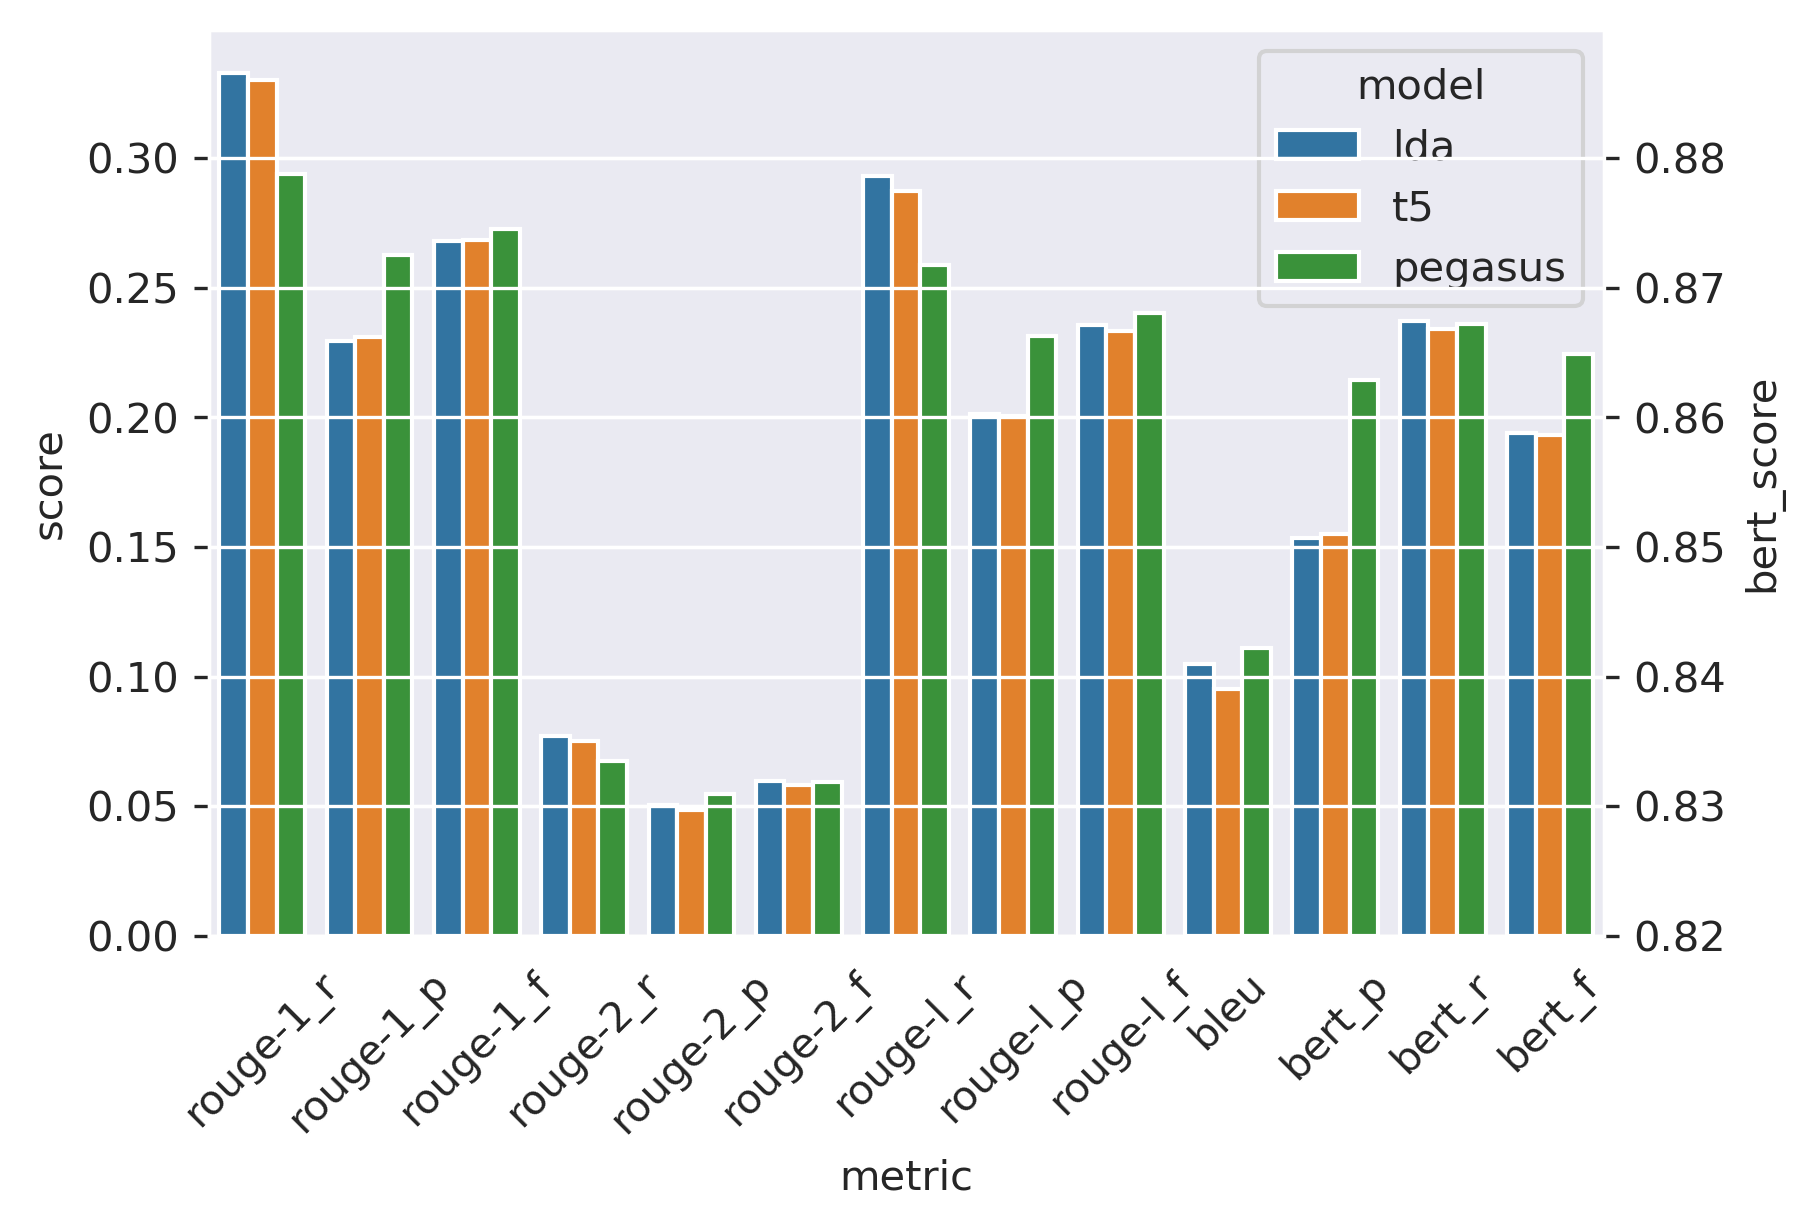

In [21]:
# SMELLY CODE

scores=all_scores(paraphrased, True)

for col in ['bert_p', 'bert_f', 'bert_r']:
    scores[col] = (scores[col] - 0.82) * 5

melted_scores = pd.melt(scores, id_vars=scores.columns[0], var_name='metric', value_name="score")
#call_figure()

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

sns.barplot(x="metric", y="score", hue='model', data=melted_scores)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round((ax1.get_yticks() / 5) + 0.82, 2))
ax2.set_ylabel('bert_score')

if SAVE_IMGS:
    plt.savefig(image_name('scores_paraphrase'), bbox_inches="tight")

plt.show()

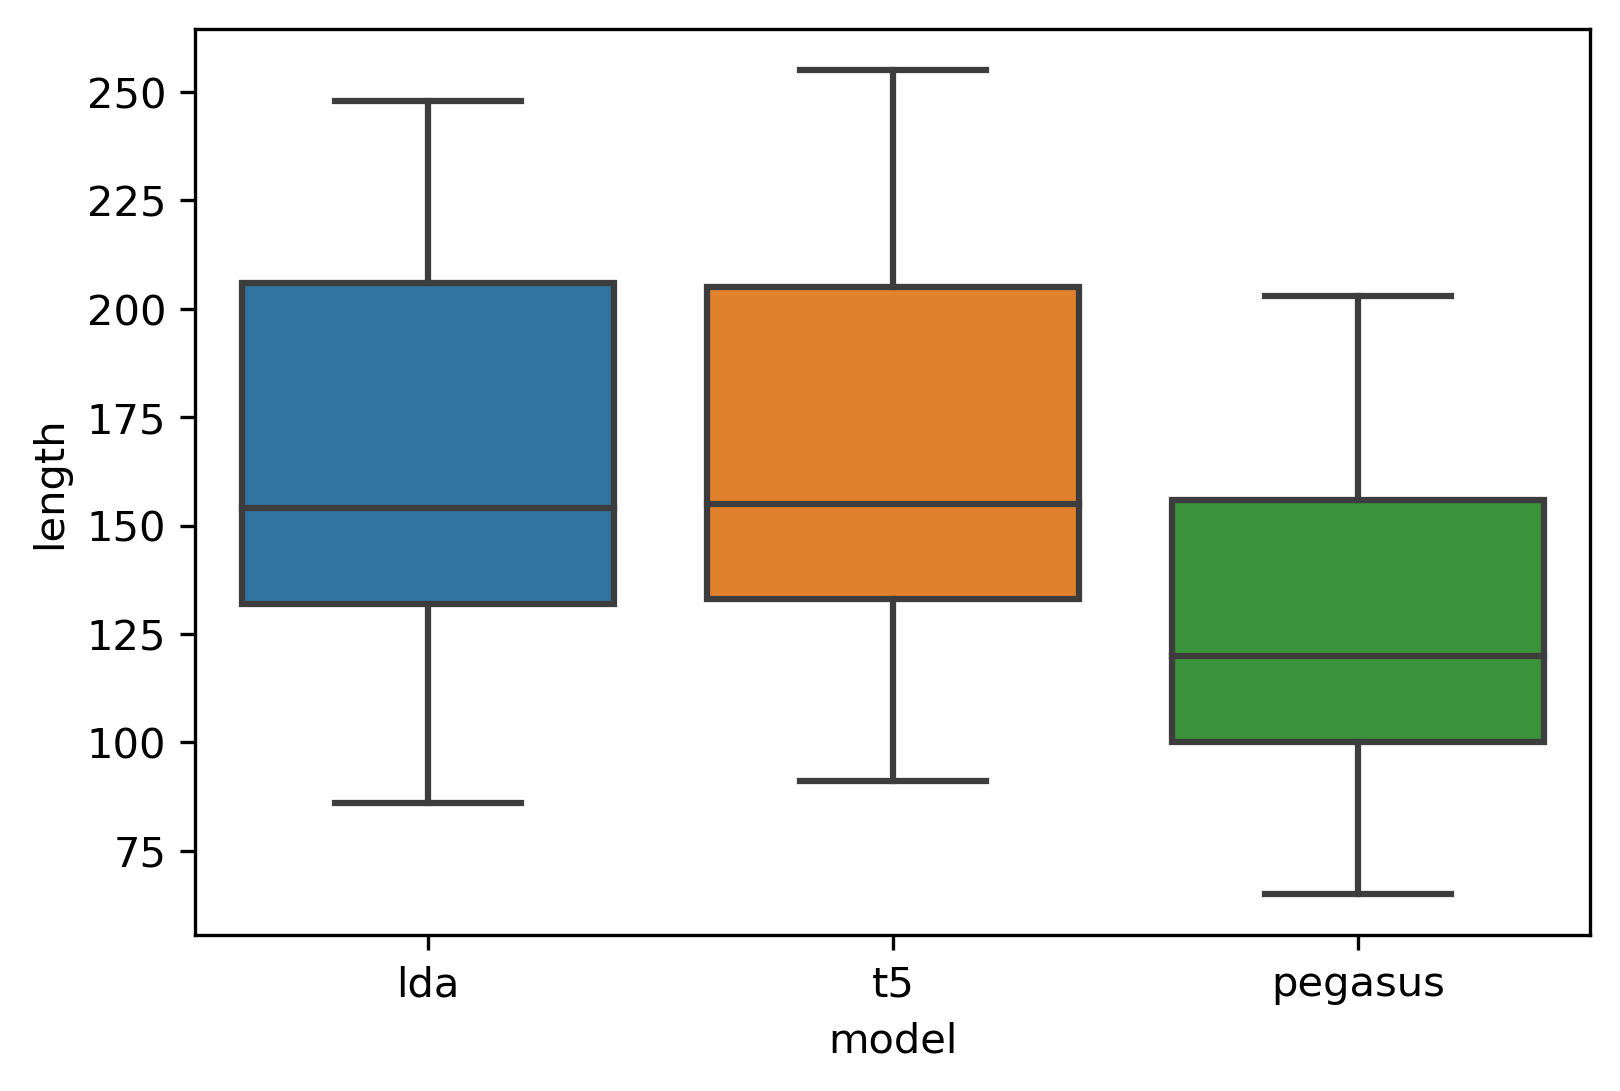

In [20]:
lengths = pd.DataFrame.from_dict(
    {model: [len(a.split()) for a in paraphrased[model]] for model in paraphrased.keys()}).melt(
    var_name='model', value_name='length')
call_figure()
sns.boxplot(data=lengths, x='model', y='length', showfliers=False)

if SAVE_IMGS:
    plt.savefig(image_name('length_paraphrase'))
plt.show()